In [2]:
#Gerekli olan kütüphanelerin tanımlanması
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np

# Pandasın istenilen sayıda satır ve float kısımda gösterilecek basamak ayarı
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

In [3]:
# veri kümesinin okunması.
train_df = pd.read_csv("california_housing_train.csv")
test_df = pd.read_csv("california_housing_test.csv")

# Veri nin değerlerinin ölçeklendirilmesi, veride herhangi bir değişimi neden olmaz sadece ölçeklendirir.
train_df["median_house_value"] /= 1000.0
test_df["median_house_value"] /= 1000.0

# Veririni tanımlanması, incelenmesi.
train_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


In [4]:
#model oluşturmak için fonkisyon tanımlanıypr 
def build_model(my_learning_rate):
  # sequential modellemesi kullanılıyor basit yönlü olduğu için . 
  #https://www.datasciencearth.com/keras-model-wars-sequential-vs-functional/ detaylı anlatıma burdaan ulaşabilirsiniz
  model = tf.keras.models.Sequential()


  # tek katman  tek nöronlu bir yapı kullanılıyor ve giriş boyutu belirlenmesi
  model.add(tf.keras.layers.Dense(units=1, 
                                  input_shape=(1,)))

  # Model derleniyor optimizer olarak Kök kare ortolaması tercih ediliyor (Adams daha başarılı) ve loss değerini 
  # ortalamanın, gerçek değer ile farkınıni karesi toplamı  şeklinde buluyor(wikipedia'dan araştırmanızı tavsiye ederim)

  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model           

# Modeli eğitmek için fonksiyon tanımlaması 

def train_model(model, df, feature, label, epochs, batch_size=None,validation_split=0.1):


  # Belirlediğimiz modele  verilen genişlik, tekrar sayısı ve veriler ile uyum sağlatıyoruz
  history = model.fit(x=df[feature],
                      y=df[label],
                      batch_size=batch_size,
                      epochs=epochs,
                     validation_split=validation_split)

                    
  # Başlangıç nokta ağırlığı bias' ı belirlenmesi.
  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1]


  epochs = history.epoch
  
  # Her tekrarda ayrı ayrı data frame'inin alınması ve gönderilmesi
  hist = pd.DataFrame(history.history)

  rmse = hist["root_mean_squared_error"]

  return epochs, rmse, history.history 


In [5]:
def plot_the_loss_curve(epochs, mae_training, mae_validation):
  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs[1:], mae_training[1:], label="Training Loss")
  plt.plot(epochs[1:], mae_validation[1:], label="Validation Loss")
  plt.legend()
  
  # train içinde ayırdığımız validation verisi ile train verisinden elde edilen loss değerini aynı grafikte gösteriyoruz

  merged_mae_lists = mae_training[1:] + mae_validation[1:]
  highest_loss = max(merged_mae_lists)
  lowest_loss = min(merged_mae_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
   
  #grafik sınırlarını ayarlıyoruz
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show()  



Epoch 1/30
136/136 [==============================] - 0s 1ms/step - loss: 40801.5547 - root_mean_squared_error: 201.9939 - val_loss: 49481.3555 - val_root_mean_squared_error: 222.4440
Epoch 2/30
136/136 [==============================] - 0s 630us/step - loss: 23657.1172 - root_mean_squared_error: 153.8087 - val_loss: 29080.6289 - val_root_mean_squared_error: 170.5304
Epoch 3/30
136/136 [==============================] - 0s 620us/step - loss: 12584.0020 - root_mean_squared_error: 112.1784 - val_loss: 15783.2207 - val_root_mean_squared_error: 125.6313
Epoch 4/30
136/136 [==============================] - 0s 615us/step - loss: 7358.0508 - root_mean_squared_error: 85.7791 - val_loss: 9669.5762 - val_root_mean_squared_error: 98.3340
Epoch 5/30
136/136 [==============================] - 0s 613us/step - loss: 6517.6001 - root_mean_squared_error: 80.7317 - val_loss: 9329.8262 - val_root_mean_squared_error: 96.5910
Epoch 6/30
136/136 [==============================] - 0s 630us/step - loss: 6513

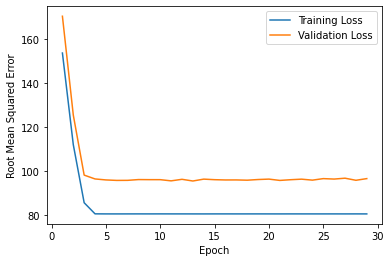

In [6]:
#  hyperparameters değerleri sırasıyla; öğrenme hızı (0.01-0.3) arası olması tavsiye edilir, tekrar sayısı, 
#  veri kümesi genişliğini seçiyoruz.
learning_rate = 0.01
learning_rate = 0.08
epochs = 30
batch_size = 100

# ayıracağımız verinin % kaç olacağının bilgisinin tanımlanması
validation_split=0.2


my_feature="median_income" 
my_label="median_house_value" 


# Modelimizi vereceğimiz değerin boş olduğundan emin oluyoruz.
my_model = None

# Model fonksiyonumuza değerleri gönderiyoruz ve modeli oluşturuyoruz

my_model = build_model(learning_rate)
epochs, rmse, history = train_model(my_model, train_df, my_feature, 
                                    my_label, epochs, batch_size, 
                                    validation_split)

plot_the_loss_curve(epochs, history["root_mean_squared_error"], 
                    history["val_root_mean_squared_error"])

- Trainin Loss ile validation loss arasında fark olması istenmeyen bir durumdur ancak benzer bir eğilim göstermesi, modelimizin belirli açıdan başarılı olduğuna işaret eder. 
- Bu farkın kaynaklandığı başlıca neden, verimizin belli bir değere göre sıralanmış olması yani validation verisi homojen olarak veri setinden alınamamasıdır.
- Çözümünde ise veri setini karıştırıp, daha homojen veri elde edeceğiz

In [7]:
shuffled_train_df = train_df.reindex(np.random.permutation(train_df.index))

Epoch 1/30
136/136 [==============================] - 0s 1ms/step - loss: 45950.8555 - root_mean_squared_error: 214.3615 - val_loss: 36803.2461 - val_root_mean_squared_error: 191.8417
Epoch 2/30
136/136 [==============================] - 0s 622us/step - loss: 27202.9902 - root_mean_squared_error: 164.9333 - val_loss: 20771.4707 - val_root_mean_squared_error: 144.1231
Epoch 3/30
136/136 [==============================] - 0s 615us/step - loss: 14737.0508 - root_mean_squared_error: 121.3963 - val_loss: 11008.7871 - val_root_mean_squared_error: 104.9228
Epoch 4/30
136/136 [==============================] - 0s 599us/step - loss: 8385.3652 - root_mean_squared_error: 91.5716 - val_loss: 7393.4707 - val_root_mean_squared_error: 85.9853
Epoch 5/30
136/136 [==============================] - 0s 637us/step - loss: 6980.0908 - root_mean_squared_error: 83.5469 - val_loss: 7234.3154 - val_root_mean_squared_error: 85.0548
Epoch 6/30
136/136 [==============================] - 0s 622us/step - loss: 6959

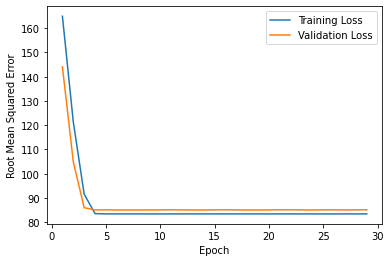

In [8]:
#  hyperparameters değerleri sırasıyla; öğrenme hızı (0.01-0.3) arası olması tavsiye edilir, tekrar sayısı, 
#  veri kümesi genişliğini seçiyoruz.
learning_rate = 0.01
epochs = 30
batch_size = 100

# ayıracağımız verinin % kaç olacağının bilgisinin tanımlanması
validation_split=0.2


my_feature="median_income" 
my_label="median_house_value" 


# Modelimizi vereceğimiz değerin boş olduğundan emin oluyoruz.
my_model = None

# Model fonksiyonumuza değerleri gönderiyoruz ve modeli oluşturuyoruz

my_model = build_model(learning_rate)
epochs, rmse, history = train_model(my_model, shuffled_train_df, my_feature, 
                                    my_label, epochs, batch_size, 
                                    validation_split)

plot_the_loss_curve(epochs, history["root_mean_squared_error"], 
                    history["val_root_mean_squared_error"])

Daha başarılı bir validation verisi seçimi gerçekleştirdik, buna bağlı olarak train verisi ile çok daha fazla benzer özellik gösterdiler.

# Modelimizi test etmek

In [9]:
#Test verimizinin içinde bulundan özellik ve etiket serilerini değişkenlere atıyoruz
x_test = test_df[my_feature]
y_test = test_df[my_label]

# ve tes
results = my_model.evaluate(x_test, y_test, batch_size=batch_size)

30/30 [==============================] - 0s 518us/step - loss: 7019.8394 - root_mean_squared_error: 83.7845


Rmse değerlerinin benzer olduğunu görmekteyiz modelimizin görece başarılı olduğunu anlayabiliriz